Trying to decouple sample error and distribution shift

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from simple_data import *
from tqdm import tqdm
from copy import deepcopy
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
from numpy import array as arr

from sklearn.decomposition import PCA

In [2]:
import warnings
warnings.filterwarnings("ignore")

# linear reg
- with + without epsilon noise
- fit one X_train, sample many X_test
- change n/p, measure test_mse, bias, variance
- shift X_test from X_train w/ covariance change and Laplace distr
- what happens in sim for non-linear models?
- dnn, rf, etc.


In [3]:
'''
n - number of samples
d - dimension
norm_beta - norm of beta
var_eps - variance of epsilon
    snr = norm_beta^2 / var_eps
'''
def gen_data(n=10, d=100, norm_beta=1, beta=None, var_eps=0.1, s=None, seed=703858704, shift_type='None', shift_val=0.1):
    npr.seed(seed=seed)
    
    # x
    x = npr.randn(n, d)
    if 'shift' in shift_type:
        x += shift_val
    elif 'scale' in shift_type:
        S2 = np.cumsum(np.ones(d))
        S2 /= np.sum(S2)
        S2 = np.diag(np.sqrt(S2 * d))
        x = x @ S2
    elif 'spike' in shift_type:
        v = np.ones(d)
        v /= npl.norm(v)
        S = np.eye(d) + (np.sqrt(shift_val) - 1) * np.outer(v, v)
        x = x @ S
    elif shift_type == 'lap':
        x = npr.laplace(size=(n, d))
    
    # beta
    if s == None:
        s = d
    if beta is None:
        beta = np.zeros(d)
        beta[:s] = npr.randn(s)
        beta[:s] /= npl.norm(beta[:s])
        if norm_beta == 'd':
            norm_beta = d
        beta[:s] *= norm_beta
    
    var_mult = 0 if var_eps == 0 else np.sqrt(var_eps)
    eps = var_mult * npr.randn(n)
    y = x @ beta + eps

    return x, y, beta

def ols(x, y):
    betahat = npl.pinv(x.T @ x) @ (x.T @ y)
    return betahat

def sgd_fit(x, y, lr=0.1):
    clf = SGDRegressor(eta0=lr, learning_rate='constant', 
                       max_iter=1, tol=1e-3, warm_start=True, fit_intercept=False)
    for i in range(x.shape[0]):
        clf.fit(x[i].reshape(1, -1), y[i].reshape(1, 1))
#     betahat = npl.pinv(x.T @ x) @ (x.T @ y)
    return clf.coef_

# yerr should be stds for each point y
def plot_with_std(x, y, yerr, label=None, linestyle='-', color=None, alpha=1.0):   
    ymin = y - yerr
    ymax = y + yerr
    plt.plot(x, y, label=label, linestyle=linestyle, alpha=alpha)
    plt.fill_between(x, ymin, ymax, alpha=0.3 * alpha)

    
    
n_train = 300
n_test = 50
num_test_reps = 15
ds = np.array([int(d) for d in [0, n_train / 10, n_train / 4, n_train / 2, n_train * 0.75, 
                                n_train * 0.8, n_train * 0.9, n_train, 
                                n_train * 1.1, n_train * 2, n_train * 10, n_train * 20,
              ]])
fit_ols = True # default True
lr = 2e-3
norm_beta = 1 #'d' default 1
var_eps = 0.1
num_nonzero_beta = None # 1
use_pca = False

# sweep num components
# num_components_list = [int(c) for c in [0, 1, 2, n_train / 10, n_train / 4, n_train / 2, n_train * 0.75, n_train * 0.9, n_train]]
# num_components_list = [int(n_train - c) for c in range(8)]
# shift_types = ['num pcs ' + str(i) for i in num_components_list]
# shift_vals = [0] * len(shift_types)

# default sweep
num_components_list = [n_train] * 6 # n_train
shift_types = ['None', 'shift', 'scale', 'spike', 'lap']
shift_vals = [0, 5, 0.1, 10, 0]

# shift one var
# shift_types = ['None', 'shift1', 'shift2', 'shift5', 'shift10']
# shift_types = ['None', 'scale1', 'scale2', 'scale5', 'scale10']
# shift_vals = [0, 1, 2, 5, 10]

# default single
# num_components_list = [n_train] * 6 # n_train
# shift_types = ['None']
# shift_vals = [0]

results = {}
for shift_type, shift_val, num_components in zip(shift_types, shift_vals, num_components_list):

    # mse_train_mean, mse_train_std = []
    mse_train = []
    mse_test_mean, mse_test_std = [], []
    # bias_test_mean, bias_test_std = []
    # var_test_mean, var_test_mean = []
    for d in tqdm(ds):
        X_train, y_train, beta = gen_data(n_train, d, norm_beta, beta=None, var_eps=var_eps, s=num_nonzero_beta)

        if use_pca and d > 0:
            pca = PCA().fit(X_train)
            X_train = pca.transform(X_train)[:, :num_components]
        
        if fit_ols or X_train.shape[0] == 0 or X_train.shape[1] == 0:
#             print(d, X_train.shape)
            betahat = ols(X_train, y_train)
        else:
            betahat = sgd_fit(X_train, y_train, lr=lr)
        mse_tests = []
        for num_test in range(num_test_reps):
            X_test, y_test, _ = gen_data(n=n_test, d=d, norm_beta=norm_beta, var_eps=var_eps, beta=beta, s=num_nonzero_beta,
                                         seed=num_test, shift_type=shift_type, shift_val=shift_val)
            
            if use_pca and d > 0:
                X_test = pca.transform(X_test)[:, :num_components]
            mse_tests.append(np.sum((X_test @ betahat - y_test)**2) / n_test)
        mse_train.append(np.sum((X_train @ betahat - y_train)**2) / n_train)
        mse_test_mean.append(np.mean(mse_tests))
        mse_test_std.append(np.std(mse_tests))
    results[shift_type] = {'mse_train': deepcopy(arr(mse_train)), 'mse_test_mean': deepcopy(arr(mse_test_mean)), 'mse_test_std': arr(mse_test_std)}

100%|██████████| 12/12 [03:45<00:00, 65.31s/it]


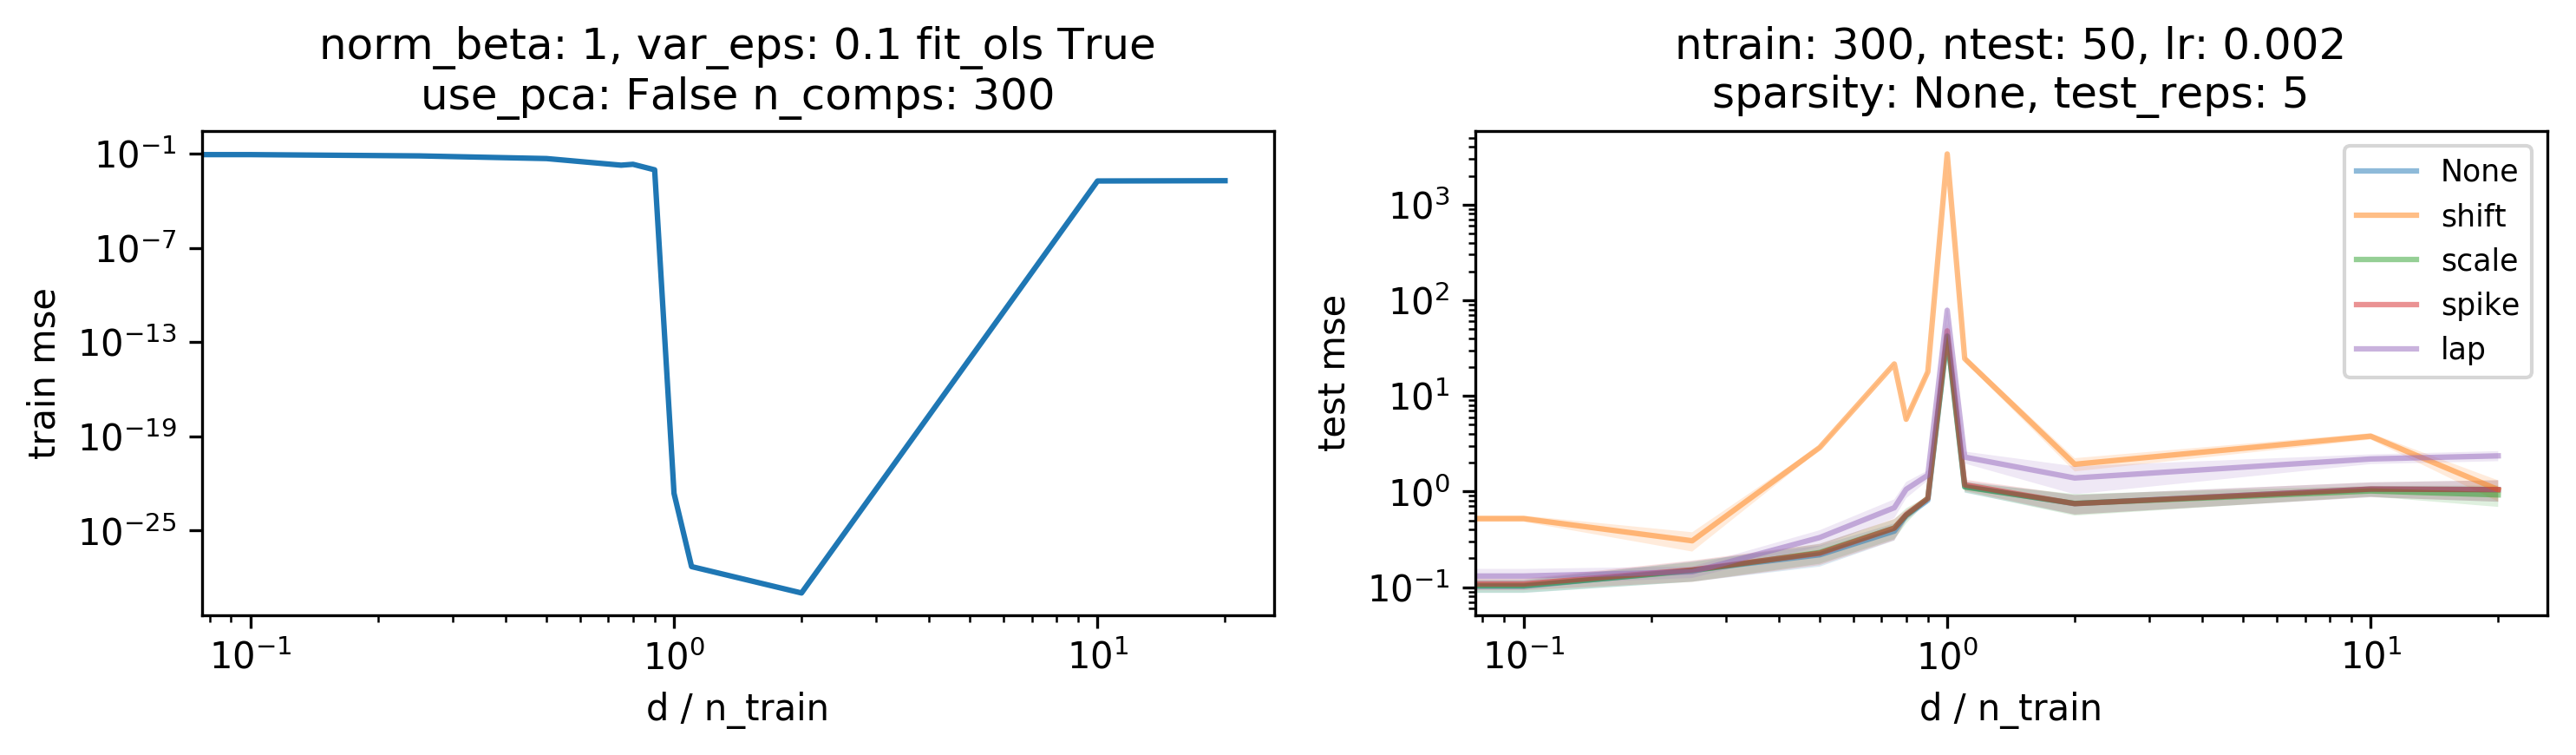

In [4]:
plt.figure(figsize=(10, 3), dpi=300)
for i, shift_type in enumerate(results.keys()):
    r = results[shift_type]
    mse_train, mse_test_mean, mse_test_std = r['mse_train'], r['mse_test_mean'], r['mse_test_std']
    R, C = 1, 3
    if i == 0:
        plt.subplot(R, C, 1)
        plt.plot(ds / n_train, mse_train, label=shift_type)
        plt.xlabel('d / n_train')
        plt.ylabel('train mse')
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'norm_beta: {norm_beta}, var_eps: {var_eps} fit_ols {fit_ols}\nuse_pca: {use_pca} n_comps: {num_components_list[0]}')


    ax = plt.subplot(R, C, 2)
    # plt.plot(ds / n_train, mse_test_mean)
    plot_with_std(ds / n_train, mse_test_mean, mse_test_std, label=shift_type, alpha=0.5)
    plt.xlabel('d / n_train')
    plt.ylabel('test mse')
    plt.xscale('log')
    plt.yscale('log')


    ax = plt.subplot(R, C, 3)
    # plt.plot(ds / n_train, mse_test_mean)
    plt.plot(ds / n_train, mse_test_std, label=shift_type, alpha=0.5)
    plt.xlabel('d / n_train')
    plt.ylabel('test std')
    plt.xscale('log')
    plt.yscale('log')
    
plt.title(f'ntrain: {n_train}, ntest: {n_test}, lr: {lr}\nsparsity: {num_nonzero_beta}, test_reps: {num_test_reps}')
ax.legend(bbox_to_anchor=(1, 1), fontsize='small')
# plt.legend()
plt.tight_layout()
plt.show()

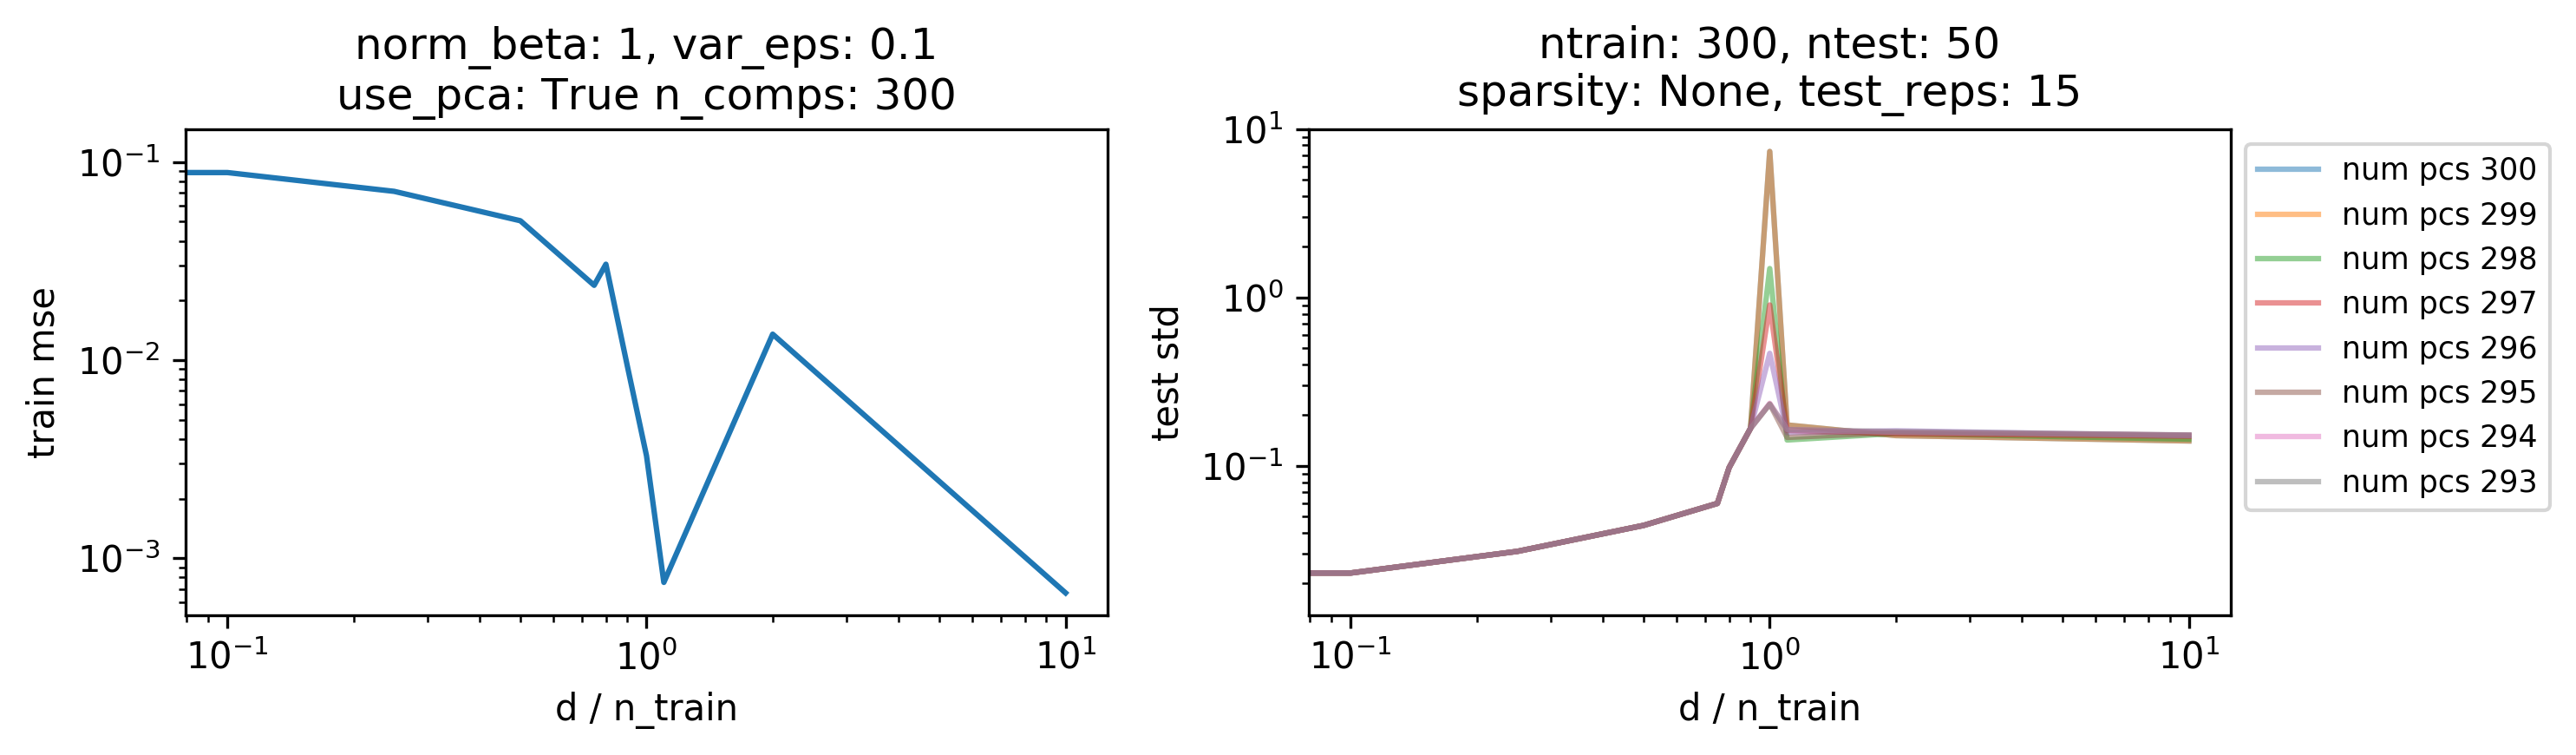

In [13]:
plt.figure(figsize=(10, 3), dpi=300)
for i, shift_type in enumerate(results.keys()):
    r = results[shift_type]
    mse_train, mse_test_mean, mse_test_std = r['mse_train'], r['mse_test_mean'], r['mse_test_std']
    R, C = 1, 2
    if i == 0:
        plt.subplot(R, C, 1)
        plt.plot(ds / n_train, mse_train, label=shift_type)
        plt.xlabel('d / n_train')
        plt.ylabel('train mse')
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'norm_beta: {norm_beta}, var_eps: {var_eps}\nuse_pca: {use_pca} n_comps: {num_components_list[0]}')



ax.legend(bbox_to_anchor=(1, 1), fontsize='small')
plt.title(f'ntrain: {n_train}, ntest: {n_test}\nsparsity: {num_nonzero_beta}, test_reps: {num_test_reps}')

# plt.legend()
plt.tight_layout()
plt.show()

# cv scoring

In [3]:
def get_scores(model_type='linear', p=1):
    train_scores = []
    test_scores = []
    ns = [2**i for i in range(5, 13)]
    print(ns)
    for n in ns:
        if model_type == 'linear':
            X, y = get_data(n, p)
            model = LinearRegression()
            cv = ShuffleSplit(n_splits=300, test_size=0.3, random_state=0)
        elif model_type == 'logistic':
            X, y_one_hot, y = generate_gaussian_data(n)
            y = y.astype(np.int)
            model = LogisticRegression(solver='lbfgs')
            cv = StratifiedShuffleSplit(n_splits=300, test_size=0.3, random_state=0)
        
        results = cross_validate(model, X, y.flatten(), cv=cv, return_train_score=True)
        train_scores.append(results['train_score'])
        test_scores.append(results['test_score'])

    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    return ns, train_scores, test_scores

# logistic regression in 1d

In [143]:
ns, train_scores, test_scores = get_scores(model_type='logistic')

[32, 64, 128, 256, 512, 1024, 2048, 4096]


train...


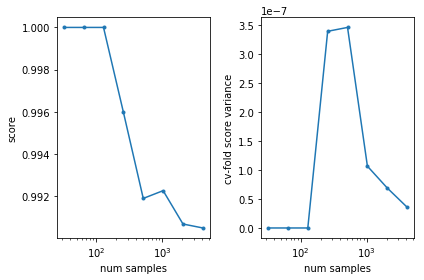

test...


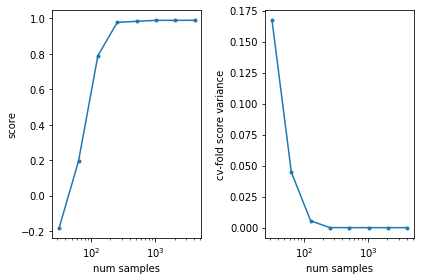

In [152]:
def plot_scores(scores):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.plot(ns, np.mean(scores, axis=1), '.-')
    plt.xscale('log')
    plt.xlabel('num samples')
    plt.ylabel('score')

    plt.subplot(R, C, 2)
    plt.plot(ns, np.var(scores, axis=1), '.-')
    plt.xscale('log')
    plt.xlabel('num samples')
    plt.ylabel('cv-fold score variance')

    plt.tight_layout()
    plt.show()

print('train...')
plot_scores(train_scores)
print('test...')
plot_scores(test_scores)

# linear reg in low dim

In [148]:
ns, train_scores, test_scores = get_scores(model_type='linear')

[32, 64, 128, 256, 512, 1024, 2048, 4096]


train...


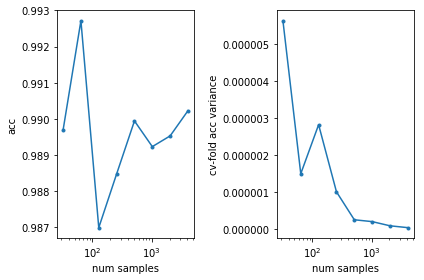

test...


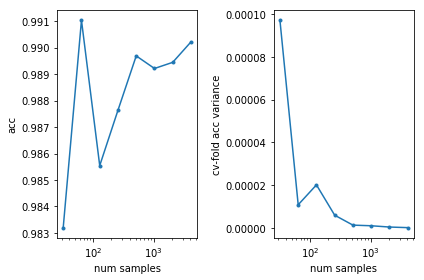

In [149]:
print('train...')
plot_scores(train_scores)
print('test...')
plot_scores(test_scores)

# linear reg in high dim

[32, 64, 128, 256, 512, 1024, 2048, 4096]
train...


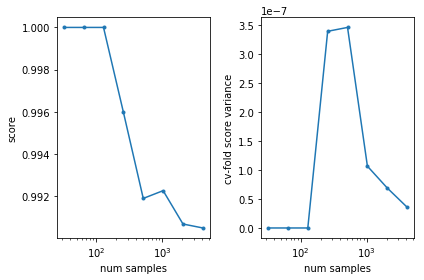

test...


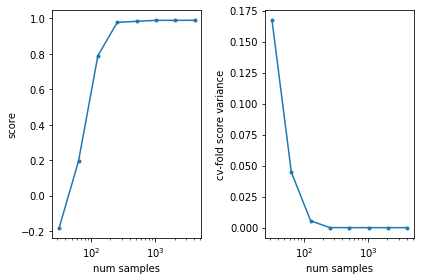

In [153]:
ns, train_scores, test_scores = get_scores(model_type='linear', p=100)

print('train...')
plot_scores(train_scores)
print('test...')
plot_scores(test_scores)